# Preparation

In [1]:
!pip3 install pandas
!pip3 install matplotlib

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple

#plt.style.use('seaborn-white')

In [19]:
# helper functions

style_ = namedtuple("style_", ["color", "marker", "linestyle"])

def load_csv_files(csv_files):
    dfs = {}
    for key, fname in csv_files.items():
        df = pd.read_csv(fname)
        dfs[key] = df[df["Skipped"] == "No"]
    return dfs

def filter_bench(dfs, query):
    if isinstance(dfs, dict):
        filtered_dfs = {}
        for key in dfs.keys():
            filtered_dfs[key] = dfs[key].query(query)
        return filtered_dfs
    else:
        return dfs.query(query)

def plot_bench(dfs, xlabel, styles, show_legend=True, title=None, ofname=None, show_xlabel=True, show_ylabel=True, log_xscale=False, log_yscale=False, font_size=14):
    fig, ax = plt.subplots(1, 1)

    ax.tick_params(labelsize=font_size)
    if(show_ylabel):
        ax.set_xlabel(xlabel, fontsize=font_size)
    if(show_ylabel):
        ax.set_ylabel("Tuples per second", fontsize=font_size)
    if(log_xscale):
        ax.set_xscale('log')
    if(log_yscale):
        ax.set_yscale('log')
    ax.set_title(title, fontsize=font_size)
    ax.grid()

    for key, df in dfs.items():        
        style = styles[key]

        #Y = df["NumInputs"].unique()[0]/df["GPU Time (sec)"]
        #Y = df["GPU Time (sec)"]
        Y = df["Elem/s (elem/sec)"]

        if xlabel in df.columns:
            X = df[xlabel]
    
            ax.plot(X, Y, label=key, color=style.color, marker=style.marker, linestyle=style.linestyle)
            ax.scatter(X, Y, color=style.color, marker=style.marker, linestyle=style.linestyle)
        else:
            ax.axhline(y=Y.iloc[0], label=key, color=style.color, linestyle=style.linestyle)

    if(show_legend):
        plt.legend(fontsize=font_size - 4)

    if(ofname):
        plt.savefig(ofname, dpi=1200, format='pdf', bbox_inches='tight')

    plt.show()

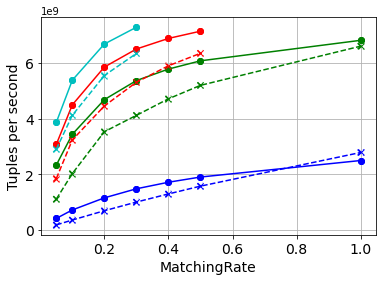

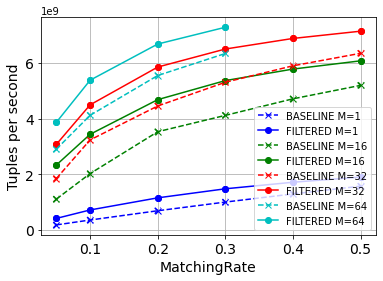

In [32]:
dfs = load_csv_files({"ALL" : "../results/join_a100.csv"})

dfs["BASELINE M=1"] = dfs["ALL"].query('Benchmark == "nvbench_hash_join" and Multiplicity == 1')
dfs["FILTERED M=1"] = dfs["ALL"].query('Benchmark == "nvbench_filtered_hash_join" and L2HitRate == 0.6 and Multiplicity == 1')
dfs["BASELINE M=16"] = dfs["ALL"].query('Benchmark == "nvbench_hash_join" and Multiplicity == 16')
dfs["FILTERED M=16"] = dfs["ALL"].query('Benchmark == "nvbench_filtered_hash_join" and L2HitRate == 0.6 and Multiplicity == 16')
dfs["BASELINE M=32"] = dfs["ALL"].query('Benchmark == "nvbench_hash_join" and Multiplicity == 32')
dfs["FILTERED M=32"] = dfs["ALL"].query('Benchmark == "nvbench_filtered_hash_join" and L2HitRate == 0.6 and Multiplicity == 32')
dfs["BASELINE M=64"] = dfs["ALL"].query('Benchmark == "nvbench_hash_join" and Multiplicity == 64')
dfs["FILTERED M=64"] = dfs["ALL"].query('Benchmark == "nvbench_filtered_hash_join" and L2HitRate == 0.6 and Multiplicity == 64')
del dfs["ALL"]

styles = {
    "BASELINE M=1" : style_('b', 'x', '--'),
    "FILTERED M=1" : style_('b', 'o', '-'),
    "BASELINE M=16" : style_('g', 'x', '--'),
    "FILTERED M=16" : style_('g', 'o', '-'),
    "BASELINE M=32" : style_('r', 'x', '--'),
    "FILTERED M=32" : style_('r', 'o', '-'),
    "BASELINE M=64" : style_('c', 'x', '--'),
    "FILTERED M=64" : style_('c', 'o', '-'),}

query = 'Skipped   == "No" and\
         Key   == "I64" and\
         Value  == "I64" and\
         SSize == 200000000'

plot_bench(filter_bench(dfs, query), "MatchingRate", styles=styles, show_legend=False)
plot_bench(filter_bench(dfs, query + ' and MatchingRate < 1.0'), "MatchingRate", styles=styles)